In [110]:
import numpy as np 
from scipy.special import j0, y0, i0
import matplotlib.pyplot as plt

#Helpers for Green function
def J0_2(omega,x,xref):
    return j0(omega*np.linalg.norm(x-xref,2,axis=-1))**2
    
def h0(s):
    return complex(j0(s),y0(s))

def Go_F(omega,x,y):
    return (1/4)*h0(omega*(np.linalg.norm(x-y,2,axis=-1)))*complex(0,1)

def G_F(omega,x,y,x_ref,rho):
    #Born Approximation of G_F for ponctual rho
    return omega**2*Go_F(omega,x,x_ref)*rho*Go_F(omega,x_ref,y) #+ Go_F(omega,x,y)

def I0_2(omega,x,xref):
    #KM approxmication. See report.
    return i0(complex(0,omega*np.linalg.norm(x-xref,2,axis=-1)))**2

Time-harmonic localization - full aperture

In [111]:
#Define transducers
N = 100 
N1 = 50
N2 = 40
R0 = 100
R1 = 50 
R2 = 20
def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles
transducers_circle = circle_points([R0],[N])[0]
transducers_linear_1 = np.vstack((np.linspace(-R1/2,R1/2,N1),np.zeros(N1))).T
transducers_linear_2 = np.vstack((np.linspace(-R2/2,R2/2,N2),np.zeros(N2))).T

#Define reflectors
x_ = 5
y_ = 5
reso = 10
x_ref = np.array([10,20])
grid = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid[k,l] = np.array([x_ref[0] + (k-reso)/reso*x_ , x_ref[1] + (l-reso)/reso*y_])

x_ref_2 = np.array([0,100])
grid_2 = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid_2[k,l] = np.array([x_ref_2[0] + (k-reso)/reso*x_ , x_ref_2[1] + (l-reso)/reso*y_])
rho = 0.5

#Define frequency bandwith
omega_o = 2*np.pi
bandwith = 0.05 * omega_o
omega_resolution = 20
omegas = np.linspace(omega_o-bandwith,omega_o+bandwith,omega_resolution)

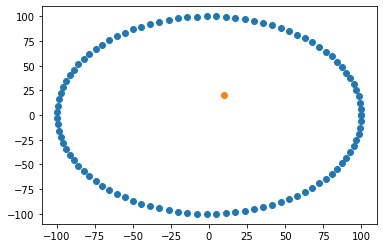

In [112]:
#Visualize the first setup
plt.scatter(transducers_circle[:,0],transducers_circle[:,1])
plt.scatter(x_ref[0],x_ref[1])
plt.show()

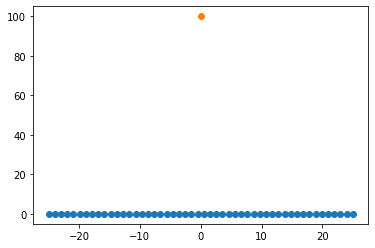

In [113]:
#Visualize the second setup
plt.scatter(transducers_linear_1[:,0],transducers_linear_1[:,1])
plt.scatter(x_ref_2[0],x_ref_2[1])

In [114]:
#Compute the dataset
U = np.ones(shape=(N,N), dtype=complex)
U1 = np.ones(shape=(N1,N1), dtype=complex)
U2 = np.ones(shape=(omega_resolution,N2,N2), dtype=complex)

for r in range(N): 
    for s in range(N):
        if s != r:
            U[r,s] = G_F(omega_o,transducers_circle[r],transducers_circle[s],x_ref,rho)
        if s ==r :
            U[r,s] = 0

for r in range(N1): 
    for s in range(N1):
        if s != r:
            U1[r,s] = G_F(omega_o,transducers_linear_1[r],transducers_linear_1[s],x_ref_2,rho)
        if s ==r :
            U1[r,s] = 0

for i in range(omega_resolution):
    omega = omegas[i]
    for r in range(N2): 
        for s in range(N2):
            if s != r:
                U2[i,r,s] = G_F(omega,transducers_linear_2[r],transducers_linear_2[s],x_ref_2,rho)
            if s == r :
                U2[i,r,s] = 0

#Add noise

In [115]:
#Compute the reverse time imaging
rho_RT = np.zeros((2*reso+1,2*reso+1))
rho_RT1 = np.zeros((2*reso+1,2*reso+1))
rho_RT2 = np.zeros((2*reso+1,2*reso+1))

for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        for r in range(N): 
            for s in range(N):
                rho_RT[k,l] += Go_F(omega_o,x_local,transducers_circle[s])*Go_F(omega_o,transducers_circle[r],x_local)*np.conj(U[r,s])
        rho_RT[k,l] *= (0.5/np.pi)
        x_local = grid_2[k,l]
        for r in range(N1): 
            for s in range(N1):
                rho_RT1[k,l] += Go_F(omega_o,x_local,transducers_linear_1[s])*Go_F(omega_o,x_local,transducers_linear_1[r])*np.conj(U1[r,s])
        rho_RT1[k,l] *= (0.5/np.pi)
        for i in range(omega_resolution):
            omega = omegas[i]
            for r in range(N2): 
                for s in range(N2):
                    rho_RT2[k,l] += Go_F(omega,x_local,transducers_linear_2[s])*omega**2*Go_F(omega,x_local,transducers_linear_2[r])*np.conj(U2[i,r,s])
        rho_RT2[k,l] *= (0.5/np.pi)
        

In [116]:
#Compute the KM imaging
rho_KM = np.zeros((2*reso+1,2*reso+1))
rho_KM1 = np.zeros((2*reso+1,2*reso+1))
rho_KM2 = np.zeros((2*reso+1,2*reso+1))

for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        for r in range(N): 
            for s in range(N):
                rho_KM[k,l] += np.exp(complex(0,omega_o*(np.linalg.norm(x_local-transducers_circle[s])+np.linalg.norm(x_local-transducers_circle[r]))))*np.conj(U[r,s])
        rho_RT[k,l] /= N**2
        x_local = grid_2[k,l]
        for r in range(N1): 
            for s in range(N1):
                rho_KM1[k,l] += np.exp(complex(0,omega_o*(np.linalg.norm(x_local-transducers_linear_1[s])+np.linalg.norm(x_local-transducers_linear_1[r]))))*np.conj(U1[r,s])
        rho_RT1[k,l] /= N1**2
        for i in range(omega_resolution):
            omega = omegas[i]
            for r in range(N2): 
                for s in range(N2):
                    rho_KM2[k,l] += np.exp(complex(0,omega*(np.linalg.norm(x_local-transducers_linear_2[s])+np.linalg.norm(x_local-transducers_linear_2[r]))))*np.conj(U2[i,r,s])
        rho_RT2[k,l] /= N2**2

In [117]:
#Compute the MUSIC-type imaging
rho_MUSIC = np.zeros((2*reso+1,2*reso+1))
u, s, vh = np.linalg.svd(U1)
v1 = u[0]
for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        g = np.zeros(N1,dtype=complex)
        for r in range(N1):
            g[r] = Go_F(omega_o,x_local,transducers_linear_1[r])
        rho_MUSIC[k,l] = np.abs(np.sum(g*v1))**2


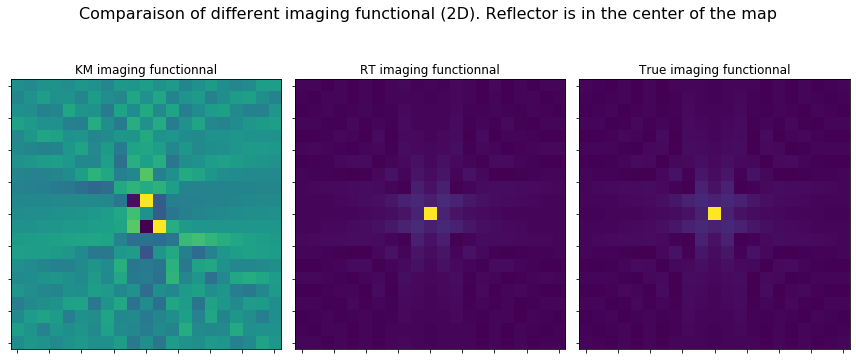

In [118]:
#Results for 2)
J = np.zeros((2*reso+1,2*reso+1))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        J[k,l] = J0_2(omega_o,x_local,x_ref)
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

ax1 = axs[0]
ax1.imshow(rho_KM.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = axs[2]
ax.imshow(J.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
axs[2].set_title('True imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()

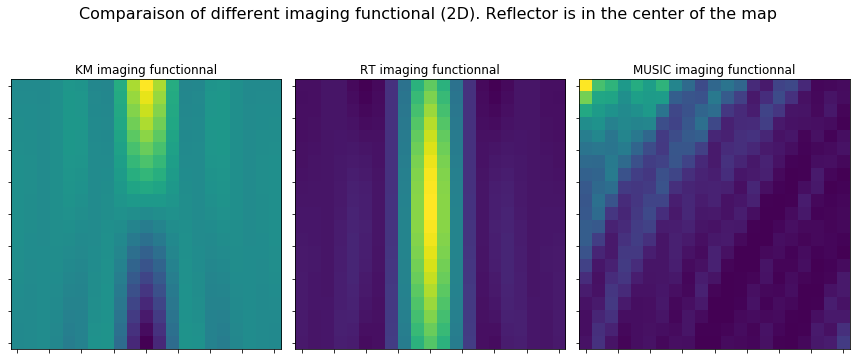

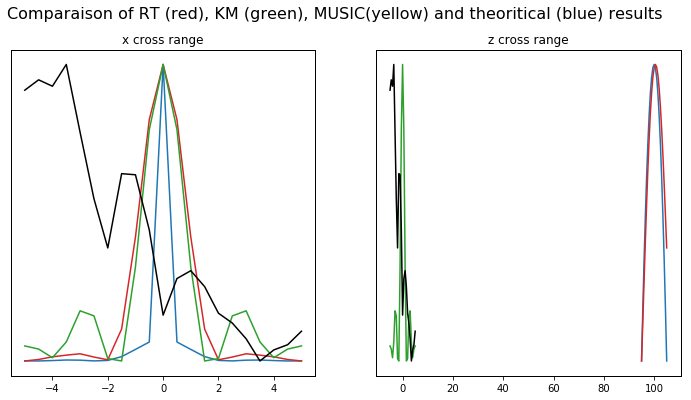

In [119]:
#Results for 3)
import scipy.integrate as integrate
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

ax1 = axs[0]
ax1.imshow(rho_KM1.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT1.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = axs[2]
ax.imshow(rho_MUSIC.T)
ax.set_xticklabels([])
ax.set_yticklabels([])

axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
axs[2].set_title('MUSIC imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
S = np.zeros(2*reso+1)
colorRT = 'tab:red'
colorKM = 'tab:green'
colorMUSIC = 'black'

z_fixed = 5
rc = 2*np.pi/omega_o * np.linalg.norm(x_ref_2) / R1
for k in range(2*reso+1):
    x_local = grid_2[k,z_fixed][0]
    S[k] = np.sinc(np.pi*(np.linalg.norm(x_local - x_ref_2[0]))/rc)**2

ax1 = axs[0]
ax1.plot(grid_2[:,z_fixed,0],S, label = 'theoritical results')
ax2 = ax1.twinx()  
ax2.plot(grid_2[:,z_fixed,0],rho_RT1[:,z_fixed], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM1[:,z_fixed], label = 'KM results', color=colorKM)
ax4 = ax1.twinx()
ax4.plot(grid_2[:,z_fixed,0],rho_MUSIC[:,z_fixed], label = 'MUSIC results', color=colorMUSIC)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

S = np.zeros(2*reso+1)
x_fixed = 5
rl = 2*2*np.pi/omega_o * np.linalg.norm(x_ref_2)**2 / R1**2
for k in range(2*reso+1):
    z_local = grid_2[x_fixed,k][1]
    S[k] = np.abs(integrate.quad(lambda x: np.exp(complex(0,-0.5*np.pi*x**2*np.linalg.norm(z_local - x_ref_2[1])/rl)), 0, 1)[0])**2

ax1 = axs[1]
ax1.plot(grid_2[x_fixed,:,1],S, label = 'theoritical results')
ax2 = ax1.twinx()  
ax2.plot(grid_2[x_fixed,:,1],rho_RT1[x_fixed,:], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM1[:,z_fixed], label = 'KM results', color=colorKM)
ax4 = ax1.twinx()
ax4.plot(grid_2[:,z_fixed,0],rho_MUSIC[:,z_fixed], label = 'MUSIC results', color=colorMUSIC)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
axs[0].set_title('x cross range')
axs[1].set_title('z cross range')
fig.suptitle('Comparaison of RT (red), KM (green), MUSIC(yellow) and theoritical (blue) results', fontsize=16)
plt.show()

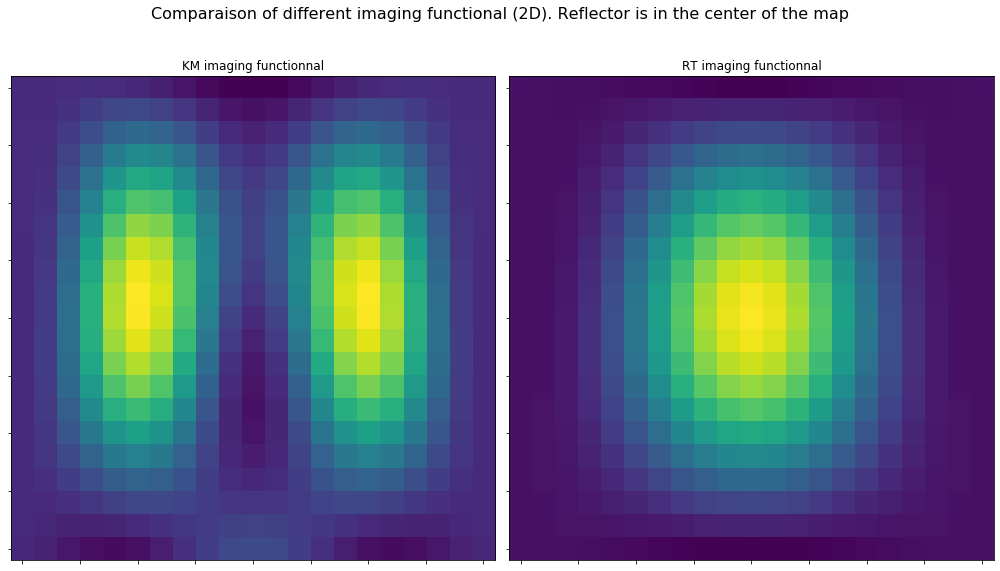

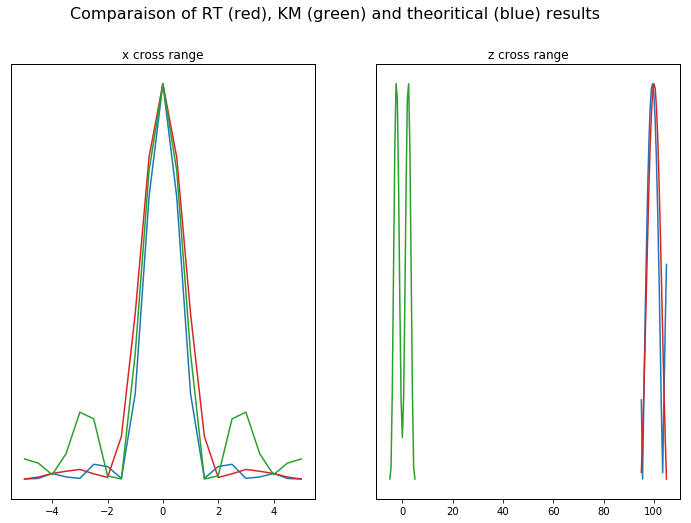

In [125]:
#Results for 4)
import scipy.integrate as integrate
fig, axs = plt.subplots(1, 2, figsize=(14, 9))

ax1 = axs[0]
ax1.imshow(rho_KM2.T)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax = axs[1]
ax.imshow(rho_RT2.T)
ax.set_xticklabels([])
ax.set_yticklabels([])


axs[0].set_title('KM imaging functionnal')
axs[1].set_title('RT imaging functionnal')
fig.suptitle('Comparaison of different imaging functional (2D). Reflector is in the center of the map', fontsize=16)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 8))
S = np.zeros(2*reso+1)
colorRT = 'tab:red'
colorKM = 'tab:green'

z_fixed = 5
rc = 2*np.pi/omega_o * np.linalg.norm(x_ref_2) / R2
for k in range(2*reso+1):
    x_local = grid_2[k,z_fixed][0]
    S[k] = np.sinc(np.pi*(np.linalg.norm(x_local - x_ref_2[0]))/rc)**2

ax1 = axs[0]
ax1.plot(grid_2[:,z_fixed,0],S, label = 'theoritical results')
ax2 = ax1.twinx()  
ax2.plot(grid_2[:,z_fixed,0],rho_RT1[:,z_fixed], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM1[:,z_fixed], label = 'KM results', color=colorKM)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

S = np.zeros(2*reso+1)
x_fixed = 5
for k in range(2*reso+1):
    z_local = grid_2[x_fixed,k][1]
    S[k] = np.abs(np.sinc(2*bandwith*(np.linalg.norm(z_local - x_ref_2[0]))/rc))

ax1 = axs[1]
ax1.plot(grid_2[x_fixed,:,1],S, label = 'theoritical results')
ax2 = ax1.twinx()  
ax2.plot(grid_2[x_fixed,:,1],rho_RT2[x_fixed,:], label = 'RT results', color=colorRT)
ax3 = ax1.twinx()
ax3.plot(grid_2[:,z_fixed,0],rho_KM2[:,z_fixed], label = 'KM results', color=colorKM)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
axs[0].set_title('x cross range')
axs[1].set_title('z cross range')
fig.suptitle('Comparaison of RT (red), KM (green) and theoritical (blue) results', fontsize=16)
plt.show()